# **0. Initial Settings**

In [1]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
dir_name = 'AI_Chem/Final_project'  # path to the folder you made starting from your google drive home directory.
if dir_name[0] == '/': dir_name = dir_name[1:]
if dir_name[-1] == '/': dir_name = dir_name[:-1]
os.chdir(f'/content/gdrive/MyDrive/{dir_name}/')


In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.6 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd


In [ ]:
### Device Setting
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device is set as: {device}")

Device is set as: cpu


# **1. Reading the CSV File and Implementing Dataset**

In [ ]:
def csv_to_data(path, data_type="train"):
    df = pd.read_csv(path)
    data = {
        "index": df["index"].to_numpy(),
        "smiles": df["smiles"].to_numpy()
    }
    if data_type == "train" or data_type == "validation":
        data["label"] = df["pkbhx"].to_numpy()
        return data
    elif data_type == "test":
        return data
    else:
        print("Wrong data type, it should be one of [train, test].")
        return None

In [ ]:

#random splitter
def random_splitter(dataset, train_ratio, validation_ratio):
  import random
  import copy
  assert train_ratio + validation_ratio == 1.0
  N = len(dataset)
  all_idx = list(range(N))
  random.shuffle(all_idx)

  train_idx = all_idx[:int(train_ratio * N)]
  print('tr_idx=', len(train_idx))
  valid_idx = all_idx[int(train_ratio * N):]
  print(len(valid_idx),'valid_idx')
  #test_idx = all_idx[int(validation_ratio * N) + int(train_ratio * N):]
  train_dataset = copy.deepcopy(dataset)
  valid_dataset = copy.deepcopy(dataset)
  #test_dataset  = copy.deepcopy(dataset)
  train_dataset.smi_list = [dataset.smi_list[i] for i in train_idx]
  train_dataset.id_list = train_idx
  train_dataset.label_list= dataset.label_list[train_idx]
  valid_dataset.smi_list = [dataset.smi_list[i] for i in valid_idx]
  valid_dataset.id_list= valid_idx
  valid_dataset.label_list= dataset.label_list[valid_idx]
  
  return train_dataset, valid_dataset

In [ ]:
# Set the csv path
train_csv_path = "/content/gdrive/MyDrive/AI_Chem/Final_project/train_set.csv"
valid_csv_path = "/content/gdrive/MyDrive/AI_Chem/Final_project/train_set.csv"

In [ ]:
class SampleDataset(Dataset):

    def __init__(self, path, data_type="train"):
        super().__init__()

        self.data = csv_to_data(path, data_type=data_type)
        self.id_list = self.data["index"]
        self.smi_list = self.data["smiles"]
        if data_type == "train" or data_type == "validation":
            self.label_list = self.data["label"]
        elif data_type == "test":
            self.label_list = None
        else:
            print("Wrong data type, it should be one of [train, test].")

    def __len__(self):
        return len(self.id_list)

    def __getitem__(self, idx):
        id = self.id_list[idx]
        smi = self.smi_list[idx]
        if self.label_list is not None:
            label = self.label_list[idx]
        else:
            label = 0.
        
        sample = dict()
    
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        sample["id"] = id
        sample["fp"] = torch.FloatTensor(fp)
        sample["label"] = torch.FloatTensor([label])
        
        return sample

In [ ]:
train_ratio= 0.8
valid_ratio= 0.2
train_dataset, valid_dataset = random_splitter(SampleDataset(train_csv_path, "train"), train_ratio, valid_ratio)
#valid_dataset = SampleDataset(valid_csv_path, "validation")

tr_idx= 308
78 valid_idx


In [ ]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
dataiter = iter(dataloader)

next(dataiter)


{'id': tensor([263, 211]), 'fp': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([[1.7400],
         [3.6600]])}

# **2. Implementing Model**

In [ ]:
class SampleModel(nn.Module):

    def __init__(self, ):
        super().__init__()
        
        self.layers = nn.Sequential(
              nn.Linear(1024, 128),
              nn.ReLU(),
              nn.Linear(128, 128),
              nn.ReLU(),
              nn.Linear(128, 1)
        )
        
    def forward(self, x,):
        h = self.layers(x)
        return h

# **3. Hyperparameter Settings**

In [ ]:

SAVE_DIR = "/content/gdrive/MyDrive/AI_Chem/Final_project/results"
BATCH_SIZE = 16
LR = 1e-3
NUM_EPOCH = 50
N_HIDDEN = 1#None
N_LAYERS = 2#None
LOSS_FN = nn.MSELoss(reduction="sum") ### Don't change


# **4. Training and Validation**

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
iter(train_dataloader)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, \
                              shuffle=False,)

In [ ]:
model = SampleModel()#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

train_loss_history, valid_loss_history = [], []
best_loss = 1e6
for i in range(1, NUM_EPOCH + 1):

    model.train()
    train_batch_losses = []
    for batch_idx, batch in enumerate(train_dataloader):
        x_batch = batch["fp"].float()#.to(device)
        y_batch = batch["label"].float()#.to(device)

        y_pred = model(x_batch)
        
        loss = LOSS_FN(y_pred, y_batch)
        train_batch_losses.append(loss.data.cpu().numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for batch_idx, batch in enumerate(valid_dataloader):
            x_batch = batch["fp"].float()#.to(device)
            y_batch = batch["label"].float()#.to(device)

            y_pred = model(x_batch)
            
            loss = LOSS_FN(y_pred, y_batch)
            valid_batch_losses.append(loss.data.cpu().numpy())

    train_avg_loss = np.mean(np.array(train_batch_losses))
    valid_avg_loss = np.mean(np.array(valid_batch_losses))
    train_loss_history.append(train_avg_loss)
    valid_loss_history.append(valid_avg_loss)
    
    if valid_avg_loss < best_loss:
        best_epoch = i
        best_loss = valid_avg_loss

    print(f"\t{i}th EPOCH --- TRAIN LOSS: {train_avg_loss:.4f} || VALIDATION LOSS: {valid_avg_loss:.4f} || BEST EPOCH: {best_epoch}", flush=True)

    torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"save_{i}.pt"))


	1th EPOCH --- TRAIN LOSS: 28.2980 || VALIDATION LOSS: 17.2456 || BEST EPOCH: 1
	2th EPOCH --- TRAIN LOSS: 10.6112 || VALIDATION LOSS: 14.7469 || BEST EPOCH: 2
	3th EPOCH --- TRAIN LOSS: 6.0601 || VALIDATION LOSS: 11.4312 || BEST EPOCH: 3
	4th EPOCH --- TRAIN LOSS: 3.4136 || VALIDATION LOSS: 9.8353 || BEST EPOCH: 4
	5th EPOCH --- TRAIN LOSS: 1.9985 || VALIDATION LOSS: 9.2336 || BEST EPOCH: 5
	6th EPOCH --- TRAIN LOSS: 1.2129 || VALIDATION LOSS: 8.9266 || BEST EPOCH: 6
	7th EPOCH --- TRAIN LOSS: 0.8636 || VALIDATION LOSS: 8.5593 || BEST EPOCH: 7
	8th EPOCH --- TRAIN LOSS: 0.6414 || VALIDATION LOSS: 8.3653 || BEST EPOCH: 8
	9th EPOCH --- TRAIN LOSS: 0.4547 || VALIDATION LOSS: 8.2447 || BEST EPOCH: 9
	10th EPOCH --- TRAIN LOSS: 0.3551 || VALIDATION LOSS: 8.2875 || BEST EPOCH: 9
	11th EPOCH --- TRAIN LOSS: 0.2919 || VALIDATION LOSS: 8.2833 || BEST EPOCH: 9
	12th EPOCH --- TRAIN LOSS: 0.2449 || VALIDATION LOSS: 8.0957 || BEST EPOCH: 12
	13th EPOCH --- TRAIN LOSS: 0.2199 || VALIDATION LOSS: 

# **5. Model Evaluation and Write the CSV File**

In [ ]:
# Set the path
best_model_save_path = "/content/gdrive/MyDrive/AI_Chem/Final_project/best_model"
best_model_save_path_full= os.path.join(best_model_save_path, f"save_{i}.pt")
test_public_csv_path = "/content/gdrive/MyDrive/AI_Chem/Final_project/test_set_public.csv"
test_private_csv_path = "/content/gdrive/MyDrive/AI_Chem/Final_project/test_set_private.csv"

test_public_dataset = SampleDataset(test_public_csv_path, "test")
test_private_dataset = SampleDataset(test_private_csv_path, "test")

test_public_dataloader = DataLoader(test_public_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_private_dataloader = DataLoader(test_private_dataset, batch_size=BATCH_SIZE, shuffle=False)


torch.save(model.state_dict(), os.path.join(best_model_save_path, f"save_{best_epoch}.pt"))
save_state_dict = torch.load(os.path.join(best_model_save_path, f"save_{best_epoch}.pt"))
model.load_state_dict(save_state_dict)

with torch.no_grad():
    test_public_indices, test_private_indices = [], []
    test_public_outputs, test_private_outputs = [], []
    for batch_idx, batch in enumerate(test_public_dataloader):
        indices = batch["id"].long()
        
        x_batch = batch["fp"].float()
        y_pred = model(x_batch) 
        
        
        test_public_indices += list(indices.data.cpu().numpy())
        test_public_outputs += list(y_pred.data.cpu().numpy())

    for batch_idx, batch in enumerate(test_private_dataloader):
        indices = batch["id"].long()
        
        x_batch = batch["fp"].float()
        y_pred = model(x_batch) 
        
        test_private_indices += list(indices.data.cpu().numpy())
        test_private_outputs += list(y_pred.data.cpu().numpy())

test_public_indices = np.array(test_public_indices)
test_public_outputs = np.array(test_public_outputs)
test_public_results = sorted([(id, val[0]) for (id, val) in \
                          zip(test_public_indices, test_public_outputs)], \
                          key=lambda x: x[0], reverse=False)
test_private_indices = np.array(test_private_indices)
test_private_outputs = np.array(test_private_outputs)
test_private_results = sorted([(id, val[0]) for (id, val) in \
                          zip(test_private_indices, test_private_outputs)], \
                          key=lambda x: x[0], reverse=False)

test_public_data = {
      "index": [res[0] for res in test_public_results],
      "pkbhx": [res[1] for res in test_public_results],
}
test_private_data = {
      "index": [res[0] for res in test_private_results],
      "pkbhx": [res[1] for res in test_private_results],
}

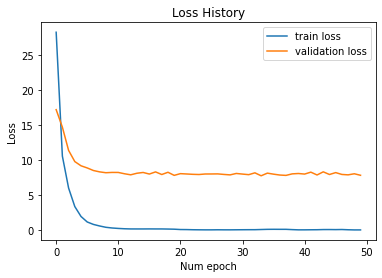

In [ ]:
import matplotlib.pyplot as plt
x_axis = np.arange(NUM_EPOCH)
fig, ax = plt.subplots()
ax.plot(x_axis, train_loss_history, label='train loss')
ax.plot(x_axis, valid_loss_history, label='validation loss')
ax.set_xlabel('Num epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss History')
ax.legend()
fig.show()

In [ ]:
def data_to_csv(data, path):
    df = pd.DataFrame(data)
    df.to_csv(path, index=False)

In [ ]:
data_to_csv(test_public_data, "./test_public_submission.csv")
data_to_csv(test_private_data, "./test_private_submission.csv")